# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import lightgbm as lgbm
import timeit

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

from catboost import CatBoostRegressor, Pool

from lightgbm import LGBMRegressor

### Изучение данных

In [2]:
df = pd.read_csv('/datasets/autos.csv')

In [3]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 354369 entries, 0 to 354368

Data columns (total 16 columns):

 #   Column             Non-Null Count   Dtype 

---  ------             --------------   ----- 

 0   DateCrawled        354369 non-null  object

 1   Price              354369 non-null  int64 

 2   VehicleType        316879 non-null  object

 3   RegistrationYear   354369 non-null  int64 

 4   Gearbox            334536 non-null  object

 5   Power              354369 non-null  int64 

 6   Model              334664 non-null  object

 7   Kilometer          354369 non-null  int64 

 8   RegistrationMonth  354369 non-null  int64 

 9   FuelType           321474 non-null  object

 10  Brand              354369 non-null  object

 11  NotRepaired        283215 non-null  object

 12  DateCreated        354369 non-null  object

 13  NumberOfPictures   354369 non-null  int64 

 14  PostalCode         354369 non-null  int64 

 15  LastSeen           354369 non-null  object

dtyp

In [5]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [6]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Посмотрим на выбросы:

Text(0, 0.5, 'Кол-во')

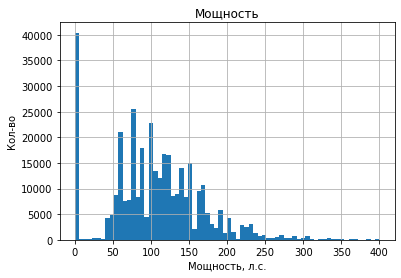

In [7]:
df['Power'].hist(bins=70, range=(0, 400))
plt.title('Мощность')
plt.xlabel('Мощность, л.с.')
plt.ylabel('Кол-во')

Text(0, 0.5, 'л.с.')

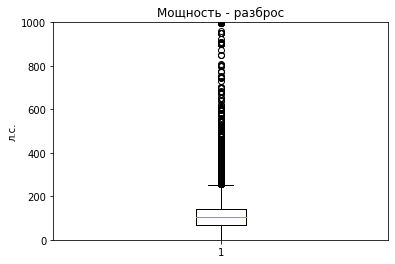

In [8]:
plt.boxplot(df['Power'])
plt.ylim(0, 1000)
plt.title('Мощность - разброс')
plt.ylabel('л.с.')

* Виден всплеск около нуля, обучению модели этот всплеск никак не поможет
* Максимальная мощность больше 2012 л.с. не существует, основываясь на самом мощном автомобиле в мире Aspark Owl.
* 50 процентов всех данных лежит в диапазоне от 50-150 л.с.

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

  warnings.warn(msg, FutureWarning)

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

  warnings.warn(


Text(0.5, 1.0, 'Price - Boxplot')

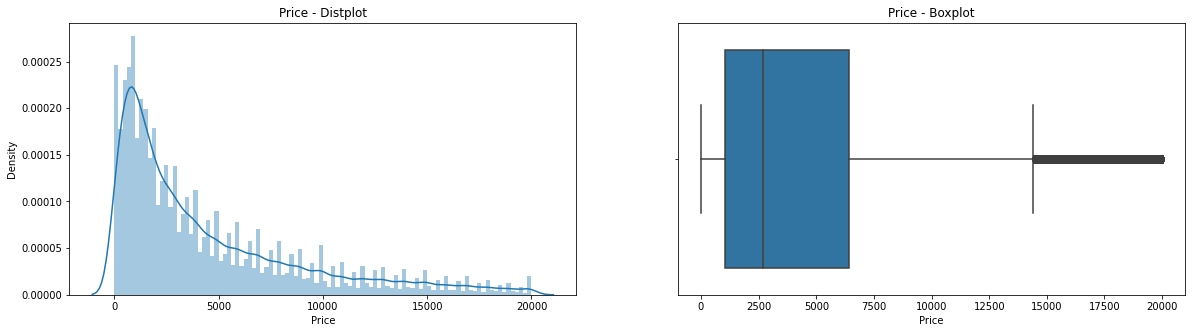

In [9]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 5))

sns.distplot(df['Price'], bins=100, ax=axes[0])
axes[0].set_title('Price - Distplot')

sns.boxplot(df['Price'], ax=axes[1])
axes[1].set_title('Price - Boxplot')

* Здесь все выглядит адекватно, поэтому оставим высокие значения.

### Выбросы

In [10]:
print('Доля выброса от всех данных:', df.query('Power == 0').shape[0] / df['Power'].shape[0])

Доля выброса от всех данных: 0.11351162206626426


11 процентов это довольно серьезная часть от всех данных, но машина стоимостью 0 евро тоже кажется нереалистичным. Хотя можно решить, что машина в настолько плохом состоянии, что её отдают за бесценок. Попробуем обучить модель на данных без выбросов.

In [11]:
df = df.query('30 <= Power < 2012') # удаление выбросов

### Пропуски

Сперва посмотрим, от какого километража входят 75 процентов значений. 

Text(0, 0.5, 'кол-во')

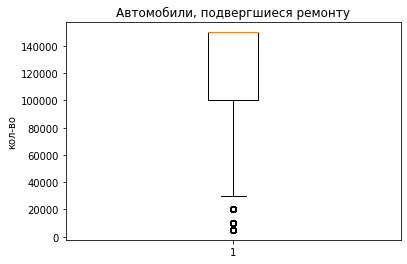

In [12]:
plt.boxplot(df[df['NotRepaired'] == 'no']['Kilometer'])
plt.title('Автомобили, подвергшиеся ремонту')
plt.ylabel('кол-во')

От ~35000 км машина уже была починена. Поэтому пропуски заполним `no` при значениях километража больше 40000 км.

In [13]:
df.loc[df['NotRepaired'].isna(), 'NotRepaired'] = (df.loc[df['NotRepaired'].isna()]['Kilometer']
                                    .apply(lambda x: 'no' if x > 40000 else 'yes'))

print(df['NotRepaired'].isna().sum())
print(df['NotRepaired'].unique())

0

['yes' 'no']


Заполним пропуски в колонке `VehicleType`

In [14]:
df['VehicleType'] = df['VehicleType'].fillna(df.groupby('Model', dropna=False)['VehicleType'] # Группировка по моделям
                                             .transform(lambda x: x.mode().iat[0])) # Подстановка названий индексов самых
                                                                                    # популярных типов кузова
                                                                                    # соответствующей модели

df['VehicleType'].isna().sum()

0

Заполним пропуски в колонке `FuelType` и `Model`

In [15]:
df['FuelType'] = df['FuelType'].fillna(df.groupby(['VehicleType'], dropna=False)['FuelType']
                                       .transform(lambda x: x.mode(dropna=False).iat[0]))

df['Model'] = df['Model'].fillna(df.groupby(['VehicleType', 'Brand'], dropna=False)['FuelType']
                                       .transform(lambda x: x.mode(dropna=False).iat[0]))

print(df['FuelType'].isna().sum())
print(df['Model'].isna().sum())

0

0


In [16]:
df['Gearbox'] = df['Gearbox'].fillna(df.groupby(['VehicleType'], dropna=False)['FuelType']
                                       .transform(lambda x: x.mode(dropna=False).iat[0]))

print(df['FuelType'].isna().sum())
print(df['Model'].isna().sum())

0

0


In [17]:
df['DateCreated'] = pd.to_datetime(df['DateCreated'], format="%Y-%m-%d %H:%M:%S")

In [18]:
df['DateCreated'].describe()

/tmp/ipykernel_178/1446076792.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.

  df['DateCreated'].describe()


count                  313120
unique                    107
top       2016-04-03 00:00:00
freq                    12317
first     2015-03-20 00:00:00
last      2016-04-07 00:00:00
Name: DateCreated, dtype: object

Определили, что верхняя планка - 2016 год.

In [19]:
df = df.drop(['DateCrawled', 'LastSeen', 'DateCreated', 'PostalCode', 'NumberOfPictures'], axis=1)

In [20]:
#КОД РЕВЬЮЕРА

df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
count,313120.000000,313120.000000,313120.000000,313120.000000,313120.000000
mean,4707.279688,2003.509897,121.406400,128691.667731,5.936769
std,4592.241607,34.983894,64.491587,36611.015183,3.614948
min,0.000000,1000.000000,30.000000,5000.000000,0.000000
25%,1250.000000,1999.000000,75.000000,125000.000000,3.000000
50%,2999.000000,2003.000000,110.000000,150000.000000,6.000000
75%,6899.000000,2008.000000,150.000000,150000.000000,9.000000
max,20000.000000,9999.000000,2009.000000,150000.000000,12.000000


In [21]:
df = df.query('Price > 400')
df = df.query('1900 < RegistrationYear < 2017')
df = df.query('RegistrationMonth > 0')

In [22]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
count,266918.000000,266918.000000,266918.000000,266918.000000,266918.000000
mean,5213.635311,2003.206689,124.014416,127553.949153,6.394904
std,4644.193812,6.300695,62.543071,36841.034836,3.346155
min,408.000000,1910.000000,30.000000,5000.000000,1.000000
25%,1599.000000,1999.000000,82.000000,125000.000000,4.000000
50%,3500.000000,2004.000000,116.000000,150000.000000,6.000000
75%,7500.000000,2007.000000,150.000000,150000.000000,9.000000
max,20000.000000,2016.000000,2009.000000,150000.000000,12.000000


### Разделение датафрейма на обучающую, валидационную и тестовую выборки

In [23]:
target = df['Price']
features = df.drop(['Price'], axis=1)

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=.4, random_state=12345)
features_test, features_valid, target_test, target_valid = train_test_split(features_test, target_test, test_size=.5, random_state=12345)

print(target_train.shape)
print(target_valid.shape)
print(target_test.shape)

(160150,)

(53384,)

(53384,)


### Прямое кодирование признаков

In [24]:
display(features_train.head())

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
204823,sedan,1998,manual,75,golf,150000,3,petrol,volkswagen,no
338525,sedan,2000,manual,101,a3,150000,3,petrol,audi,no
180205,wagon,1997,manual,145,other,150000,6,petrol,ford,no
64937,wagon,2010,manual,109,focus,100000,3,gasoline,ford,no
322126,sedan,1998,manual,90,carisma,125000,8,petrol,mitsubishi,no


In [25]:
# Создание списка с названиями колонок категориальных значений
cat_columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

# Воспроизведение прямого кодирования
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
features_train_ohe = pd.DataFrame(enc.fit_transform(features_train[cat_columns]))
features_valid_ohe = enc.transform(features_valid[cat_columns])
features_test_ohe = enc.transform(features_test[cat_columns])

features_train_ohe.shape, features_valid_ohe.shape, features_test_ohe.shape

((160150, 311), (53384, 311), (53384, 311))

Кодировка прошла успешно, теперь утечки быть не должно.

In [26]:
features_train = features_train.drop(cat_columns, axis=1)
features_valid = features_valid.drop(cat_columns, axis=1)
features_test = features_test.drop(cat_columns, axis=1)

features_train = features_train.reset_index(drop=True)
features_valid = features_valid.reset_index(drop=True)
features_test = features_test.reset_index(drop=True)

In [27]:
# приведение к одному типу данных для последующего соединения
features_train_ohe = features_train_ohe.astype('int64')
features_valid_ohe = features_valid_ohe.astype('int64')
features_test_ohe = features_test_ohe.astype('int64')

# перевод матрицы в датафрейм с сохранением номеров строк features_train
features_train_ohe = pd.DataFrame(features_train_ohe, index=features_train.index)
features_valid_ohe = pd.DataFrame(features_valid_ohe, index=features_valid.index)
features_test_ohe = pd.DataFrame(features_test_ohe, index=features_test.index)

# соединение количественных признаков с закодированными категориальными
features_train_merge = features_train.join(features_train_ohe, how='left')
features_valid_merge = features_valid.join(features_valid_ohe, how='left')
features_test_merge = features_test.join(features_test_ohe, how='left')

In [28]:
print(features_train_merge.isna().sum())
print()
print(features_valid_merge.isna().sum())
print()
print(features_test_merge.isna().sum())

RegistrationYear     0

Power                0

Kilometer            0

RegistrationMonth    0

0                    0

                    ..

306                  0

307                  0

308                  0

309                  0

310                  0

Length: 315, dtype: int64



RegistrationYear     0

Power                0

Kilometer            0

RegistrationMonth    0

0                    0

                    ..

306                  0

307                  0

308                  0

309                  0

310                  0

Length: 315, dtype: int64



RegistrationYear     0

Power                0

Kilometer            0

RegistrationMonth    0

0                    0

                    ..

306                  0

307                  0

308                  0

309                  0

310                  0

Length: 315, dtype: int64


## Обучение моделей

### Линейная регрессия

In [29]:
lin_reg_model = LinearRegression()

lin_reg_model.fit(features_train_merge, target_train)

predictions_valid = lin_reg_model.predict(features_valid_merge)

rmse = mean_squared_error(target_valid, predictions_valid, squared=False)

print('RMSE Линейной регрессии', rmse)

RMSE Линейной регрессии 2685.8956144140507


### Решающее дерево

In [30]:
random_parameters = {'max_depth': range(1, 31, 1)}

dtr = DecisionTreeRegressor(random_state=12345)

model_dtr = RandomizedSearchCV(estimator=dtr,
                               param_distributions=random_parameters,
                               random_state=12345,
                                  n_jobs=-1,
                                      scoring='neg_root_mean_squared_error')

model_dtr.fit(features_train_merge, target_train)

print("RMSE лучшей модели: ", model_dtr.best_score_)
print("Лучшие параметры: ", model_dtr.best_params_)

RMSE лучшей модели:  -1916.6086079837714

Лучшие параметры:  {'max_depth': 16}


In [31]:
print('RMSE лучшей модели:  -2050.6274254346836')
print('Лучшие параметры:  "max_depth": 13')

RMSE лучшей модели:  -2050.6274254346836

Лучшие параметры:  "max_depth": 13


### CatBoostRegressor

In [32]:
# разделение на пулы для более быстрой работы модели

train_pool = Pool(data=features_train_merge,
                 label=target_train)

valid_pool = Pool(data=features_valid_merge,
                 label=target_valid)

test_pool = Pool(data=features_test_merge,
                label=target_test)

In [33]:
model_cb = CatBoostRegressor(loss_function='RMSE')

In [34]:
grid = {'iterations': [100, 150, 200],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}

model_cb.grid_search(grid, train_pool)

0:	learn: 6820.7380586	test: 6849.0927084	best: 6849.0927084 (0)	total: 64.6ms	remaining: 6.4s

1:	learn: 6663.6526529	test: 6692.2236346	best: 6692.2236346 (1)	total: 77.4ms	remaining: 3.79s

2:	learn: 6511.9860870	test: 6540.6883531	best: 6540.6883531 (2)	total: 90.1ms	remaining: 2.91s

3:	learn: 6365.9994684	test: 6394.9850384	best: 6394.9850384 (3)	total: 102ms	remaining: 2.46s

4:	learn: 6224.2371883	test: 6253.5602819	best: 6253.5602819 (4)	total: 115ms	remaining: 2.18s

5:	learn: 6088.8674406	test: 6118.2472563	best: 6118.2472563 (5)	total: 128ms	remaining: 2s

6:	learn: 5958.6207585	test: 5988.1120525	best: 5988.1120525 (6)	total: 143ms	remaining: 1.89s

7:	learn: 5833.0854263	test: 5862.3617646	best: 5862.3617646 (7)	total: 157ms	remaining: 1.81s

8:	learn: 5710.0461620	test: 5739.7363829	best: 5739.7363829 (8)	total: 169ms	remaining: 1.71s

9:	learn: 5591.8069567	test: 5621.8808728	best: 5621.8808728 (9)	total: 182ms	remaining: 1.64s

10:	learn: 5478.3674105	test: 5508.851347

{'params': {'depth': 8,
  'iterations': 200,
  'learning_rate': 0.1,
  'l2_leaf_reg': 0.2},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               4

In [35]:
print(model_cb.get_best_score())

{'learn': {'RMSE': 1614.066780200654}}


In [36]:
print('"params": "depth": 8, "iterations": 200, "learning_rate": 0.1, "l2_leaf_reg": 0.2}')

"params": "depth": 8, "iterations": 200, "learning_rate": 0.1, "l2_leaf_reg": 0.2}


### LGBMRegressor


In [37]:
# Также происходит деление на data для работы LGBM
train_data = lgbm.Dataset(features_train_merge, label=target_train)
valid_data = lgbm.Dataset(features_valid_merge, label=target_valid)
test_data = lgbm.Dataset(features_test_merge, label=target_test)

In [38]:
param_test ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

In [39]:
n_HP_points_to_test = 5

clf = lgbm.LGBMRegressor(max_depth=-1, random_state=12345, n_jobs=4, n_estimators=1000)
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    scoring='neg_root_mean_squared_error',
    cv=3,
    refit=True,
    random_state=314,
    verbose=True)

In [40]:
fit_params={"early_stopping_rounds":30, 
            "eval_metric" : 'rmse', 
            "eval_set" : [(features_valid_merge, target_valid)],
            'eval_names': ['valid'],
            'verbose': 100,
            'categorical_feature': 'auto'}

In [41]:
gs.fit(features_train_merge, target_train, **fit_params)
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

Fitting 3 folds for each of 5 candidates, totalling 15 fits


/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid's rmse: 1746.63	valid's l2: 3.05071e+06

[200]	valid's rmse: 1702.89	valid's l2: 2.89982e+06

[300]	valid's rmse: 1682.52	valid's l2: 2.83087e+06

[400]	valid's rmse: 1667.53	valid's l2: 2.78066e+06

[500]	valid's rmse: 1656.63	valid's l2: 2.74441e+06

[600]	valid's rmse: 1647.52	valid's l2: 2.71432e+06

[700]	valid's rmse: 1642.01	valid's l2: 2.69619e+06

[800]	valid's rmse: 1636.69	valid's l2: 2.67875e+06

[900]	valid's rmse: 1631.57	valid's l2: 2.66202e+06

[1000]	valid's rmse: 1628.09	valid's l2: 2.65067e+06


/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid's rmse: 1743.29	valid's l2: 3.03907e+06

[200]	valid's rmse: 1700.65	valid's l2: 2.89223e+06

[300]	valid's rmse: 1681.36	valid's l2: 2.82697e+06

[400]	valid's rmse: 1668.9	valid's l2: 2.78522e+06

[500]	valid's rmse: 1657.92	valid's l2: 2.7487e+06

[600]	valid's rmse: 1650.12	valid's l2: 2.72288e+06

[700]	valid's rmse: 1643.74	valid's l2: 2.70187e+06

[800]	valid's rmse: 1637.91	valid's l2: 2.68274e+06

[900]	valid's rmse: 1633.84	valid's l2: 2.66945e+06

[1000]	valid's rmse: 1629.42	valid's l2: 2.65501e+06


/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid's rmse: 1747.01	valid's l2: 3.05203e+06

[200]	valid's rmse: 1702.88	valid's l2: 2.89979e+06

[300]	valid's rmse: 1683.31	valid's l2: 2.83352e+06

[400]	valid's rmse: 1669.49	valid's l2: 2.78721e+06

[500]	valid's rmse: 1659.41	valid's l2: 2.75365e+06

[600]	valid's rmse: 1651.77	valid's l2: 2.72836e+06

[700]	valid's rmse: 1645.56	valid's l2: 2.70785e+06

[800]	valid's rmse: 1640.93	valid's l2: 2.69266e+06

[900]	valid's rmse: 1636.11	valid's l2: 2.67684e+06

[1000]	valid's rmse: 1631.75	valid's l2: 2.66261e+06


/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid's rmse: 1713.34	valid's l2: 2.93554e+06

[200]	valid's rmse: 1666.01	valid's l2: 2.77561e+06

[300]	valid's rmse: 1643.96	valid's l2: 2.7026e+06

[400]	valid's rmse: 1630.71	valid's l2: 2.65923e+06

[500]	valid's rmse: 1621.29	valid's l2: 2.62857e+06

[600]	valid's rmse: 1614.87	valid's l2: 2.60781e+06

[700]	valid's rmse: 1609.01	valid's l2: 2.58893e+06

[800]	valid's rmse: 1604.05	valid's l2: 2.57297e+06

[900]	valid's rmse: 1600.66	valid's l2: 2.56212e+06

[1000]	valid's rmse: 1597.5	valid's l2: 2.552e+06


/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid's rmse: 1709.68	valid's l2: 2.92301e+06

[200]	valid's rmse: 1666.69	valid's l2: 2.77786e+06

[300]	valid's rmse: 1647.25	valid's l2: 2.71345e+06

[400]	valid's rmse: 1633.79	valid's l2: 2.66928e+06

[500]	valid's rmse: 1624.25	valid's l2: 2.63818e+06

[600]	valid's rmse: 1617.75	valid's l2: 2.61711e+06

[700]	valid's rmse: 1612.43	valid's l2: 2.59992e+06

[800]	valid's rmse: 1607.97	valid's l2: 2.58557e+06

[900]	valid's rmse: 1604.19	valid's l2: 2.57341e+06

[1000]	valid's rmse: 1601.14	valid's l2: 2.56365e+06


/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid's rmse: 1713.95	valid's l2: 2.93762e+06

[200]	valid's rmse: 1670.6	valid's l2: 2.79089e+06

[300]	valid's rmse: 1647.99	valid's l2: 2.71588e+06

[400]	valid's rmse: 1634.43	valid's l2: 2.67137e+06

[500]	valid's rmse: 1624.47	valid's l2: 2.6389e+06

[600]	valid's rmse: 1618.22	valid's l2: 2.61865e+06

[700]	valid's rmse: 1613.73	valid's l2: 2.60413e+06

[800]	valid's rmse: 1608.86	valid's l2: 2.58844e+06

[900]	valid's rmse: 1604.39	valid's l2: 2.57407e+06

[1000]	valid's rmse: 1601.05	valid's l2: 2.56335e+06


/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid's rmse: 2288.66	valid's l2: 5.23797e+06

[200]	valid's rmse: 2227.47	valid's l2: 4.96164e+06

[300]	valid's rmse: 2200.36	valid's l2: 4.8416e+06

[400]	valid's rmse: 2183.38	valid's l2: 4.76714e+06

[500]	valid's rmse: 2170.77	valid's l2: 4.71224e+06

[600]	valid's rmse: 2160.82	valid's l2: 4.66916e+06

[700]	valid's rmse: 2152.05	valid's l2: 4.63131e+06

[800]	valid's rmse: 2144.27	valid's l2: 4.59791e+06

[900]	valid's rmse: 2137.12	valid's l2: 4.56727e+06

[1000]	valid's rmse: 2132.3	valid's l2: 4.54669e+06


/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid's rmse: 2289.33	valid's l2: 5.24101e+06

[200]	valid's rmse: 2231.05	valid's l2: 4.97757e+06

[300]	valid's rmse: 2200.72	valid's l2: 4.84316e+06

[400]	valid's rmse: 2182.79	valid's l2: 4.76459e+06

[500]	valid's rmse: 2170.85	valid's l2: 4.71259e+06

[600]	valid's rmse: 2161.2	valid's l2: 4.6708e+06

[700]	valid's rmse: 2152.87	valid's l2: 4.63486e+06

[800]	valid's rmse: 2145.73	valid's l2: 4.60415e+06

[900]	valid's rmse: 2139.5	valid's l2: 4.57746e+06

[1000]	valid's rmse: 2133.91	valid's l2: 4.55359e+06


/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid's rmse: 2288.73	valid's l2: 5.23827e+06

[200]	valid's rmse: 2225.86	valid's l2: 4.95444e+06

[300]	valid's rmse: 2198.24	valid's l2: 4.83228e+06

[400]	valid's rmse: 2180.99	valid's l2: 4.75672e+06

[500]	valid's rmse: 2167.12	valid's l2: 4.6964e+06

[600]	valid's rmse: 2158.36	valid's l2: 4.65851e+06

[700]	valid's rmse: 2150.29	valid's l2: 4.62377e+06

[800]	valid's rmse: 2143.5	valid's l2: 4.59458e+06

[900]	valid's rmse: 2137.23	valid's l2: 4.56773e+06

[1000]	valid's rmse: 2131.75	valid's l2: 4.54438e+06


/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid's rmse: 1790.76	valid's l2: 3.20681e+06

[200]	valid's rmse: 1742.77	valid's l2: 3.03726e+06

[300]	valid's rmse: 1720.68	valid's l2: 2.96075e+06

[400]	valid's rmse: 1706.63	valid's l2: 2.91259e+06

[500]	valid's rmse: 1696.63	valid's l2: 2.87856e+06

[600]	valid's rmse: 1688.58	valid's l2: 2.8513e+06

[700]	valid's rmse: 1682.16	valid's l2: 2.82967e+06

[800]	valid's rmse: 1676.47	valid's l2: 2.81056e+06

[900]	valid's rmse: 1671.34	valid's l2: 2.79336e+06

[1000]	valid's rmse: 1667.14	valid's l2: 2.77936e+06


/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid's rmse: 1787.6	valid's l2: 3.1955e+06

[200]	valid's rmse: 1743.73	valid's l2: 3.04059e+06

[300]	valid's rmse: 1722.55	valid's l2: 2.96719e+06

[400]	valid's rmse: 1708.36	valid's l2: 2.9185e+06

[500]	valid's rmse: 1698.78	valid's l2: 2.88587e+06

[600]	valid's rmse: 1690.76	valid's l2: 2.85867e+06

[700]	valid's rmse: 1683.35	valid's l2: 2.83367e+06

[800]	valid's rmse: 1677.67	valid's l2: 2.81459e+06

[900]	valid's rmse: 1673.23	valid's l2: 2.7997e+06

[1000]	valid's rmse: 1669.34	valid's l2: 2.78671e+06


/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid's rmse: 1795.11	valid's l2: 3.22243e+06

[200]	valid's rmse: 1747.19	valid's l2: 3.05269e+06

[300]	valid's rmse: 1724.14	valid's l2: 2.97265e+06

[400]	valid's rmse: 1709.71	valid's l2: 2.9231e+06

[500]	valid's rmse: 1698.96	valid's l2: 2.88647e+06

[600]	valid's rmse: 1690.39	valid's l2: 2.85743e+06

[700]	valid's rmse: 1684.1	valid's l2: 2.8362e+06

[800]	valid's rmse: 1678.52	valid's l2: 2.81744e+06

[900]	valid's rmse: 1673.9	valid's l2: 2.80193e+06

[1000]	valid's rmse: 1669.19	valid's l2: 2.78618e+06


/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid's rmse: 1761.46	valid's l2: 3.10274e+06

[200]	valid's rmse: 1720.63	valid's l2: 2.96056e+06

[300]	valid's rmse: 1702.06	valid's l2: 2.897e+06

[400]	valid's rmse: 1687.3	valid's l2: 2.847e+06

[500]	valid's rmse: 1677.41	valid's l2: 2.81371e+06

[600]	valid's rmse: 1670	valid's l2: 2.7889e+06

[700]	valid's rmse: 1663.67	valid's l2: 2.76779e+06

[800]	valid's rmse: 1658.33	valid's l2: 2.75007e+06

[900]	valid's rmse: 1654.1	valid's l2: 2.73606e+06

[1000]	valid's rmse: 1650.22	valid's l2: 2.72322e+06


/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid's rmse: 1762.74	valid's l2: 3.10725e+06

[200]	valid's rmse: 1723.28	valid's l2: 2.96969e+06

[300]	valid's rmse: 1703.39	valid's l2: 2.90154e+06

[400]	valid's rmse: 1688.83	valid's l2: 2.85215e+06

[500]	valid's rmse: 1679.64	valid's l2: 2.82119e+06

[600]	valid's rmse: 1672.41	valid's l2: 2.79695e+06

[700]	valid's rmse: 1666.35	valid's l2: 2.77673e+06

[800]	valid's rmse: 1660.88	valid's l2: 2.75853e+06

[900]	valid's rmse: 1656.47	valid's l2: 2.7439e+06

[1000]	valid's rmse: 1652.54	valid's l2: 2.7309e+06


/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid's rmse: 1759.62	valid's l2: 3.09626e+06

[200]	valid's rmse: 1719.36	valid's l2: 2.9562e+06

[300]	valid's rmse: 1699.79	valid's l2: 2.88928e+06

[400]	valid's rmse: 1687.18	valid's l2: 2.84656e+06

[500]	valid's rmse: 1677.61	valid's l2: 2.81438e+06

[600]	valid's rmse: 1670.78	valid's l2: 2.79152e+06

[700]	valid's rmse: 1664.87	valid's l2: 2.7718e+06

[800]	valid's rmse: 1660.07	valid's l2: 2.75583e+06

[900]	valid's rmse: 1655.57	valid's l2: 2.7409e+06

[1000]	valid's rmse: 1651.24	valid's l2: 2.72659e+06


/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid's rmse: 1697.86	valid's l2: 2.88272e+06

[200]	valid's rmse: 1649.46	valid's l2: 2.72071e+06

[300]	valid's rmse: 1627.09	valid's l2: 2.64742e+06

[400]	valid's rmse: 1611.47	valid's l2: 2.59685e+06

[500]	valid's rmse: 1600.11	valid's l2: 2.56036e+06

[600]	valid's rmse: 1591.24	valid's l2: 2.53206e+06

[700]	valid's rmse: 1584.72	valid's l2: 2.51134e+06

[800]	valid's rmse: 1579.81	valid's l2: 2.49581e+06

[900]	valid's rmse: 1575.09	valid's l2: 2.4809e+06

[1000]	valid's rmse: 1571.33	valid's l2: 2.46908e+06

Best score reached: -1601.2712387371557 with params: {'colsample_bytree': 0.9731668400523877, 'min_child_samples': 171, 'min_child_weight': 1e-05, 'num_leaves': 41, 'reg_alpha': 10, 'reg_lambda': 100, 'subsample': 0.5575732396028996} 


In [42]:
print('rmse', '1775.5169674329388')

rmse 1775.5169674329388


## Анализ моделей

Сравним две самые точные и быстрые модели между собой: `CatBoost` и `LGBM`

In [43]:
result_fit_cb = %timeit -n1 -r1 -o sum(range(1000000))

model_cb2 = CatBoostRegressor(learning_rate=.1, depth=8, iterations=200, l2_leaf_reg=.2)
model_cb2.fit(train_pool)

16.5 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

0:	learn: 4332.1510185	total: 29.8ms	remaining: 5.93s

1:	learn: 4049.7995931	total: 59.3ms	remaining: 5.87s

2:	learn: 3802.6295088	total: 88.9ms	remaining: 5.84s

3:	learn: 3583.0871389	total: 117ms	remaining: 5.75s

4:	learn: 3392.3550277	total: 146ms	remaining: 5.7s

5:	learn: 3217.9086500	total: 174ms	remaining: 5.63s

6:	learn: 3071.0447542	total: 202ms	remaining: 5.58s

7:	learn: 2933.1351640	total: 230ms	remaining: 5.53s

8:	learn: 2818.5774330	total: 259ms	remaining: 5.5s

9:	learn: 2711.2908884	total: 286ms	remaining: 5.44s

10:	learn: 2618.5376127	total: 313ms	remaining: 5.37s

11:	learn: 2539.6340667	total: 343ms	remaining: 5.37s

12:	learn: 2470.3419060	total: 372ms	remaining: 5.36s

13:	learn: 2409.3842357	total: 399ms	remaining: 5.3s

14:	learn: 2355.4296562	total: 428ms	remaining: 5.28s

15:	learn: 2306.8764187	total: 454ms	remaining: 5.22s

16:	learn: 2264.2948799	total: 485ms	remaining: 5.22s

17:	learn

In [44]:
result_predict_cb = %timeit -n1 -r1 -o sum(range(1000000))

predictions_cb = model_cb2.predict(test_pool)

print('Catboost RMSE', mean_squared_error(target_test, predictions_cb, squared=False))

16.6 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

Catboost RMSE 1649.5509578727085


In [45]:
result_fit_lgbm = %timeit -n1 -r1 -o sum(range(1000000))

model_lgbm2 = LGBMRegressor(colsample_bytree = 0.9731668400523877,
                            min_child_samples = 171,
                            min_child_weight = 1e-05,
                            num_leaves = 41,
                            reg_alpha = 10,
                            reg_lambda = 100,
                            subsample = 0.5575732396028996,
                            random_state = 12345
                           )

model_lgbm2.fit(features_train_merge, target_train)

19.1 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


LGBMRegressor(colsample_bytree=0.9731668400523877, min_child_samples=171,
              min_child_weight=1e-05, num_leaves=41, random_state=12345,
              reg_alpha=10, reg_lambda=100, subsample=0.5575732396028996)

In [46]:
result_predictions_lgbm = %timeit -n1 -r1 -o sum(range(1000000))

predictions_lgbm = model_lgbm2.predict(features_test_merge)
print('LGBM RMSE', mean_squared_error(target_test, predictions_lgbm, squared=False))

15.7 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

LGBM RMSE 1691.7637907025087


In [47]:
columns = ['CatBoost', 'LightGBM']
indexes = ['fit', 'predict']
values = [[result_fit_cb, result_predict_cb], [result_fit_lgbm, result_predictions_lgbm]]

In [48]:
comparasion = pd.DataFrame(values, index=indexes, columns=columns)

comparasion

,CatBoost,LightGBM
fit,16.5 ms ± 0 ns per loop (mean ± std. dev. of 1...,16.6 ms ± 0 ns per loop (mean ± std. dev. of 1...
predict,19.1 ms ± 0 ns per loop (mean ± std. dev. of 1...,15.7 ms ± 0 ns per loop (mean ± std. dev. of 1...


## Вывод

* Удалены признаки, не влиящую на обучение модели
* Заполнены пропуски через условия и группировки для более "натурального" вида
* Обучены 4 модели
* При обучении самая быстрой моделью является `CatBoost`
* При предсказании самой быстрой моделью является `LightGBM`

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей